# Data Importing & Pre-Processing

## Importing all the files

Files:
 * ```capture_file```, description of the file.


### To-do list

#### ```capture_file```
 - [X] Filter uplink data traffic from the phone.
 - [X] .


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_extraction import read_from_pcap, read_from_wav
from preprocessing import feature_expansion_raw

from preprocessing import flow_creation, binary_labeler


In [5]:
captures_dir = "captures/" 
captures_files = [captures_dir + f"network/capture_test-0{i}.cap" for i in range(5,10)]

captures = [read_from_pcap(path=f) for f in captures_files]

ringtone_capture = read_from_wav(filename=captures_dir + "audio/ringtone.wav")

In [6]:
captures_pd = list(map(lambda x: feature_expansion_raw(x), captures))

In [7]:
captures_pd[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SourceAddress       1105 non-null   object 
 1   DestinationAddress  1763 non-null   object 
 2   Duration            1763 non-null   object 
 3   PacketLength        1763 non-null   int64  
 4   Timestamp           1763 non-null   float64
 5   TimestampOffset     1763 non-null   float64
 6   TransmissionTime    1763 non-null   float64
 7   Bandwidth           1763 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 110.3+ KB


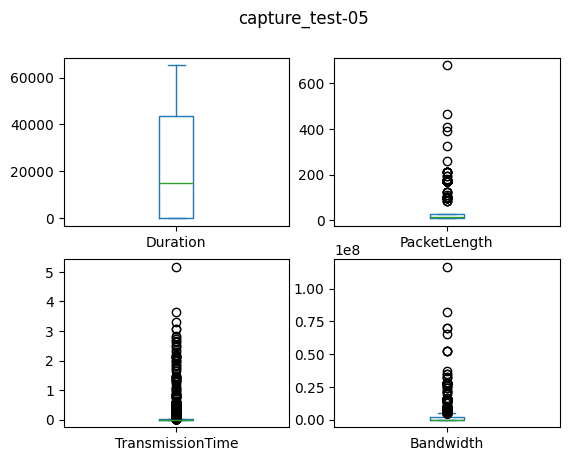

In [8]:
fig, axs = plt.subplots(2, 2)
plot_cols = ["Duration", "PacketLength", "TransmissionTime", "Bandwidth"]

fig.suptitle("capture_test-05")
for i, c in zip(axs.flat, plot_cols):
    captures_pd[0][c].plot.box(ax=i)

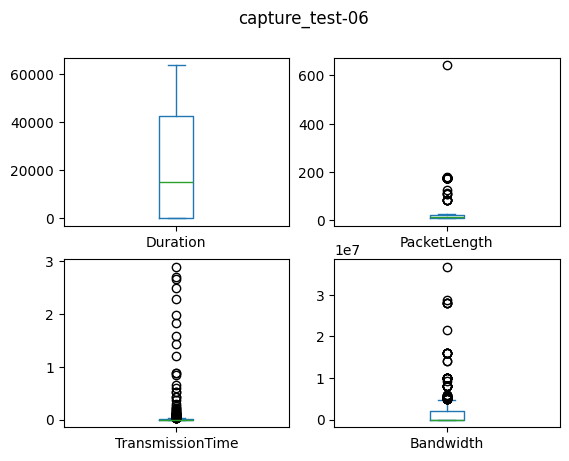

In [9]:
fig, axs = plt.subplots(2, 2)
plot_cols = ["Duration", "PacketLength", "TransmissionTime", "Bandwidth"]

fig.suptitle("capture_test-06")
for i, c in zip(axs.flat, plot_cols):
    captures_pd[1][c].plot.box(ax=i)

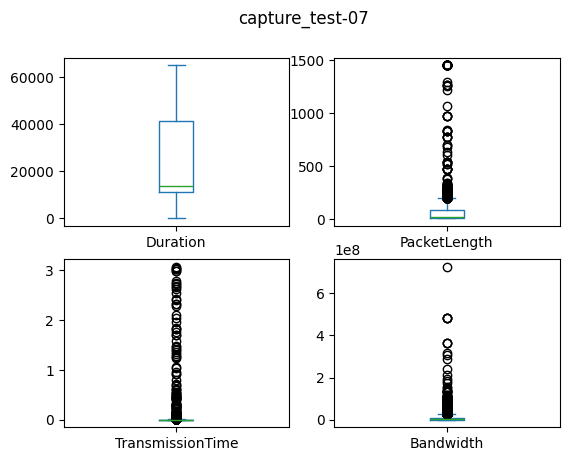

In [10]:
fig, axs = plt.subplots(2, 2)
plot_cols = ["Duration", "PacketLength", "TransmissionTime", "Bandwidth"]

fig.suptitle("capture_test-07")
for i, c in zip(axs.flat, plot_cols):
    captures_pd[2][c].plot.box(ax=i)

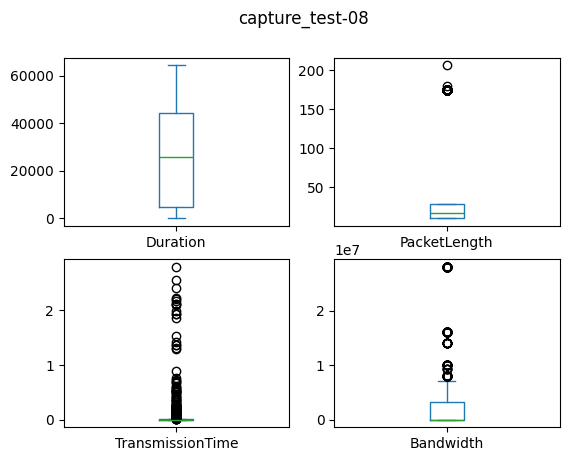

In [11]:
fig, axs = plt.subplots(2, 2)
plot_cols = ["Duration", "PacketLength", "TransmissionTime", "Bandwidth"]

fig.suptitle("capture_test-08")
for i, c in zip(axs.flat, plot_cols):
    captures_pd[3][c].plot.box(ax=i)

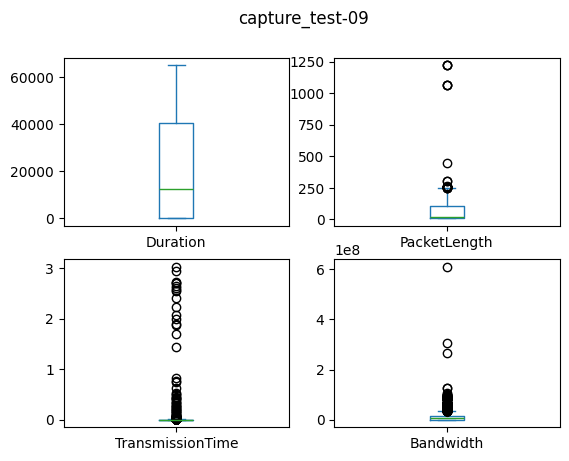

In [12]:
fig, axs = plt.subplots(2, 2)
plot_cols = ["Duration", "PacketLength", "TransmissionTime", "Bandwidth"]

fig.suptitle("capture_test-09")
for i, c in zip(axs.flat, plot_cols):
    captures_pd[4][c].plot.box(ax=i)

## Data Cleaning

### ```capture_test-05```

In [13]:
captures_pd[0].loc[:, "SourceAddress"].unique()

array(['28:39:26:3b:f0:d7', '00:c0:ca:a9:cd:ce', 'ce:e1:bf:00:9a:ca',
       None, '44:48:c1:74:f0:01', '44:48:c1:74:ef:01',
       '44:48:c1:74:ef:00', 'a8:9c:ed:68:ae:71', '00:c0:ca:a9:e7:52',
       '02:c0:ca:a9:cd:ce', '48:5f:99:a8:3b:1f', '5e:4b:d4:81:9d:b6',
       '6c:c4:9f:4b:46:61', '7c:c2:25:9c:f3:e4', '86:6b:8a:20:05:76',
       'ba:5f:26:3f:9e:1a', '44:48:c1:74:f0:61', '64:79:f0:2b:a2:00'],
      dtype=object)

### ```capture_test-06```

In [14]:
captures_pd[1].loc[:, "SourceAddress"].unique()
target_source_address = "ce:e1:bf:00:9a:ca"
filtered_capture_6 = captures_pd[1].loc[captures_pd[1]["SourceAddress"] == target_source_address, :]

In [15]:
flows_6 = flow_creation(captures_pd[1])
flows_6_labeled = binary_labeler(flows=flows_6, criterion=target_source_address, label_name="IsMicrophone", label_values=(0,0))
flows_6_labeled.drop(labels=[None], axis=0, inplace=True)
flows_6_labeled.to_csv("datasets/capture_test-06_flows_labeled.csv")

In [16]:
flows_6_labeled

,Duration_mean,Duration_sd,Bandwidth_sd,CDF_pl,IsMicrophone
00:c0:ca:a9:cd:ce,23604.662921,15274.37575,6512009.231902,1868.0,0
ce:e1:bf:00:9a:ca,21872.487179,7299.870878,8483043.411449,294.0,0
7c:c2:25:9c:f3:e4,31621.969697,29933.691172,3421846.909625,128.0,0
28:39:26:3b:f0:d7,37704.52,16944.703949,3466977.658647,108.0,0
02:c0:ca:a9:cd:ce,46166.333333,122.742605,4573996.259477,128.0,0
00:c0:ca:a9:e7:52,2901.333333,9452.24012,1395520.063226,112.0,0
44:48:c1:74:ef:00,40448.0,0.0,3078749.469133,16.0,0


In [17]:
filtered_capture_6

,SourceAddress,DestinationAddress,Duration,PacketLength,Timestamp,TimestampOffset,TransmissionTime,Bandwidth
4,ce:e1:bf:00:9a:ca,00:c0:ca:a9:cd:ce,26114,24,1.705422e+09,1.874525,0.855028,2.806926e+01
5,ce:e1:bf:00:9a:ca,00:c0:ca:a9:cd:ce,26114,24,1.705422e+09,1.875136,0.000611,3.927987e+04
6,ce:e1:bf:00:9a:ca,00:c0:ca:a9:cd:ce,26114,24,1.705422e+09,1.876036,0.000900,2.666667e+04
7,ce:e1:bf:00:9a:ca,00:c0:ca:a9:cd:ce,26114,24,1.705422e+09,1.886045,0.010009,2.397842e+03
8,ce:e1:bf:00:9a:ca,00:c0:ca:a9:cd:ce,26114,24,1.705422e+09,1.887352,0.001307,1.836266e+04
9,ce:e1:bf:00:9a:ca,00:c0:ca:a9:cd:ce,26114,24,1.705422e+09,1.890585,0.003233,7.423446e+03
10,ce:e1:bf:00:9a:ca,00:c0:ca:a9:cd:ce,26114,24,1.705422e+09,1.979511,0.088926,2.698873e+02
11,ce:e1:bf:00:9a:ca,00:c0:ca:a9:cd:ce,26114,24,1.705422e+09,2.104550,0.125039,1.919401e+02
12,ce:e1:bf:00:9a:ca,00:c0:ca:a9:cd:ce,26114,24,1.705422e+09,2.105587,0.001037,2.314368e+04
129,ce:e1:bf:00:9a:ca,00:c0:ca:a9:cd:ce,11264,24,1.705422e+09,17.168276,0.046302,5.183361e+02


### ```capture_test-07```

#### Cleaning

In [18]:
captures_pd[2].loc[:, "SourceAddress"].unique()
target_source_address = "ce:e1:bf:00:9a:ca"
filtered_capture_7 = captures_pd[2].loc[captures_pd[2]["SourceAddress"] == target_source_address, :]

#### Saving cleaned sample

In [19]:
filtered_capture_7.to_csv("datasets/capture_test-07_filtered.csv")

#### Causality?

Text(0.5, 1.0, 'PacketLength through time')

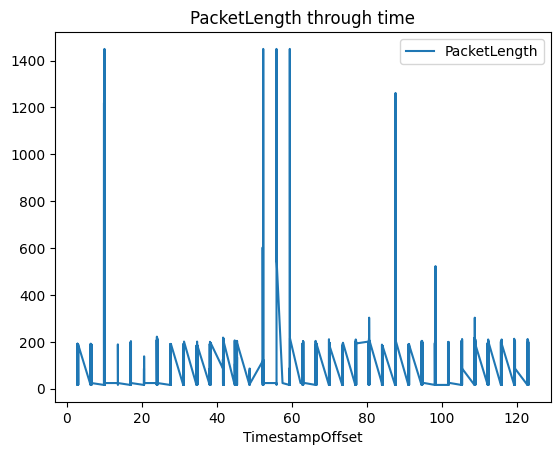

In [20]:
filtered_capture_7.plot.line(x="TimestampOffset", y="PacketLength", label="PacketLength")
plt.title("PacketLength through time")

Text(0.5, 1.0, 'Ringtone track')

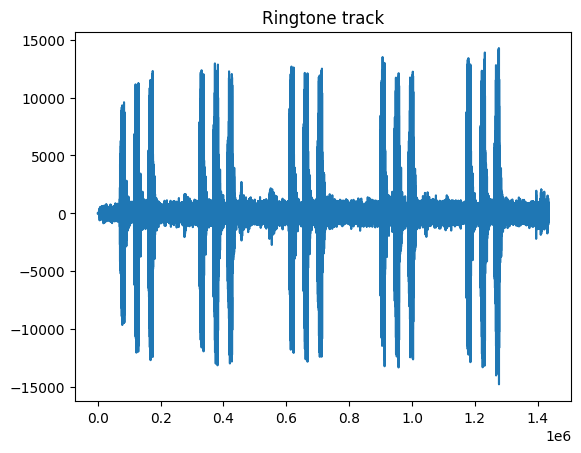

In [21]:
plt.plot(list(range(len(ringtone_capture[1]))), ringtone_capture[1], label="Pressure")
plt.title("Ringtone track")

In [22]:
len(ringtone_capture[1]), filtered_capture_7.shape[0]

(1434624, 2444)

In [23]:
offset = 0
kernel_size = int(len(ringtone_capture[1]) / (filtered_capture_7.shape[0] - offset))
convolved, sampled = [], []
iters = filtered_capture_7.shape[0] - offset
sampled += [0] * offset
for i in range(iters):
    sampled.append(ringtone_capture[1][i*kernel_size])

Text(0.5, 1.0, 'Sampled ringtone track')

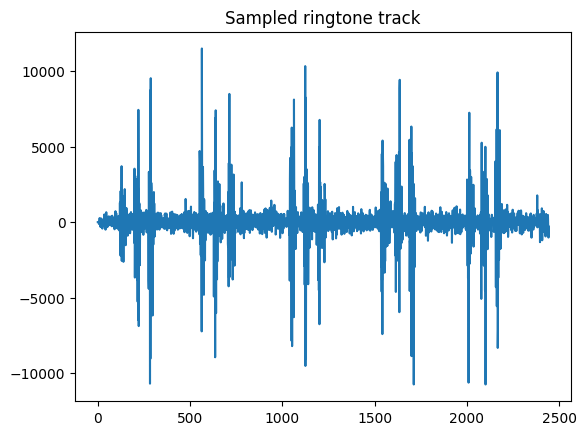

In [24]:
plt.plot(list(range(len(sampled))), sampled, label="Pressure")
plt.title("Sampled ringtone track")

In [63]:
def sample_audio(sound_capture: list[float], network_capture: pd.DataFrame):
    """
    Downsamples the sound capture in such a way such the length of the list audio track and the list network capture are the same.

    Args:
        sound_capture (list[float]): List of floats that represents the sound samples.
        network_capture (pd.DataFrame): Pandas DataFrame of the cleaned captured file.

    Returns:
        list[float]: The downsampled audio file, as a list of floats.
    """
    kernel_size = int(len(sound_capture) / network_capture.shape[0])
    return sound_capture[::kernel_size]

def plot_audio_network_comparison(sound_capture: list[float], network_capture: pd.DataFrame):
    """Plots the comparison between the audio capture and the network capture.

    Args:
        sound_capture (list[float]): List of floats that represents the sound samples.
        network_capture (pd.DataFrame): Pandas DataFrame of the cleaned captured file.
    """
    sampled = sample_audio(sound_capture=sound_capture, network_capture=network_capture)
    x_axis = list(range(len(sampled)))
    fig, ax1 = plt.subplots()
    
    color = 'tab:blue'
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude', color=color)
    ax1.plot(x_axis, sampled, color=color, label="Amplitude")
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Length (bytes)', color=color) 
    ax2.plot(x_axis[:network_capture.shape[0]], network_capture["PacketLength"], color=color, alpha=.75, label="PacketLength")
    ax2.set_ylim([-network_capture["PacketLength"].max(), network_capture["PacketLength"].max()])
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title("Network traffic & Recorded sound comparison")
    fig.legend()
    fig.show()
    pass

/tmp/ipykernel_53425/1031003247.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


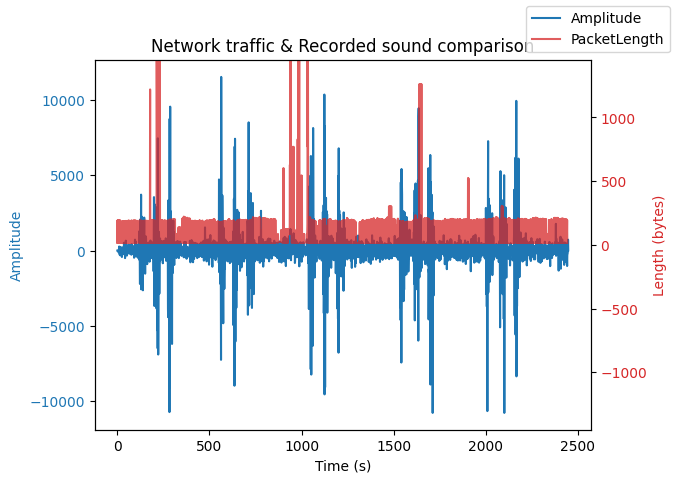

In [64]:
plot_audio_network_comparison(sound_capture=ringtone_capture[1], network_capture=filtered_capture_7)

In [27]:
from granger_causality import is_granger_caused, grangers_causation_matrix
concat_pd = pd.concat([filtered_capture_7.reset_index()["PacketLength"], pd.Series(sampled)], axis=1)
concat_pd.columns = ["PacketLength", "Sound"]
grange_caus_mat = grangers_causation_matrix(data=concat_pd, variables=concat_pd.columns, verbose=False, maxlag=20)
print(is_granger_caused(granger_causality_table=grange_caus_mat, y="PacketLength", x="Sound", threshold=.05))

/home/sicco/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/sicco/.local/lib/python3.10/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/sicco/.local/lib/python3.10/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
/home/sicco/.local/lib/python3.10/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/home/sicco/.local/lib/python3.10/site-packages/statsmode

True


In [28]:
grange_caus_mat

,PacketLength_x,Sound_x
PacketLength_y,0.9999,0.0189
Sound_y,0.0919,1.0000


#### Labeling and Saving

In [29]:
import importlib
import preprocessing #import the module here, so that it can be reloaded.
importlib.reload(preprocessing)

<module 'preprocessing' from '/home/sicco/Documents/ATCNS_project/atcns-demo/preprocessing.py'>

In [30]:
flows_7 = flow_creation(captures_pd[2])
flows_7_labeled = binary_labeler(flows=flows_7, criterion=target_source_address, label_name="IsMicrophone")
flows_7_labeled.drop(labels=[None], axis=0, inplace=True)
flows_7_labeled.to_csv("datasets/capture_test-07_flows_labeled.csv")

In [31]:
flows_7_labeled


,Duration_mean,Duration_sd,Bandwidth_sd,CDF_pl,IsMicrophone
00:c0:ca:a9:cd:ce,20644.399281,18301.848699,32556370.260066,42142.0,0
ce:e1:bf:00:9a:ca,25936.177578,15453.030386,29855415.259898,66252.0,1
00:c0:ca:a9:e7:52,10476.209945,18732.294909,3347261.894687,2232.0,0
28:39:26:3b:f0:d7,35028.770492,19675.315796,3368248.859964,820.0,0
7c:c2:25:9c:f3:e4,16684.481203,24054.148377,3855475.586644,720.0,0
02:c0:ca:a9:cd:ce,45374.217391,685.189541,5592893.742553,192.0,0
48:5f:99:a8:3b:1f,41562.130435,9302.188504,971591.848486,192.0,0


### ```capture_test-08```

#### Filtering and cleaning

In [32]:
captures_pd[3].loc[:, "SourceAddress"].unique()
target_source_address = "ce:e1:bf:00:9a:ca"
filtered_capture_8 = captures_pd[3].loc[captures_pd[3]["SourceAddress"] == target_source_address, :]
filtered_capture_8.to_csv("datasets/capture_test-08_filtered.csv")

flows_8 = flow_creation(captures_pd[3])
flows_8_labeled = binary_labeler(flows=flows_8, criterion=target_source_address, label_name="IsMicrophone", label_values=(0,0))
flows_8_labeled.drop(labels=[None], axis=0, inplace=True)
filtered_capture_8.to_csv("datasets/capture_test-08_flows_labeled.csv")


flows_8_labeled

,Duration_mean,Duration_sd,Bandwidth_sd,CDF_pl,IsMicrophone
00:c0:ca:a9:cd:ce,27050.457746,14990.840742,4112145.590545,6824.0,0
6c:c4:9f:4b:50:61,24128.955224,23347.660316,12777669.184209,356.0,0
c8:89:f3:b3:ea:f6,27325.410959,23592.02544,11945306.93516,348.0,0
28:39:26:3b:f0:d7,38839.714286,19147.844186,3216594.55447,76.0,0
48:5f:99:a8:3b:1f,44033.0,6237.16038,1135.050395,32.0,0
44:48:c1:74:ef:00,42775.272727,3429.739964,2388539.47675,48.0,0
ce:e1:bf:00:9a:ca,26114.0,0.0,13661.831307,24.0,0
44:48:c1:74:ef:01,28227.473282,20562.248451,6980548.503289,1260.0,0
00:c0:ca:a9:e7:52,267.130435,1281.11256,1621734.920799,168.0,0
7c:c2:25:9c:f3:e4,22118.6,28030.153367,1647985.701907,16.0,0


### ```capture_test-09```

#### Filtering and Cleaning

In [33]:
captures_pd[4].loc[:, "SourceAddress"].unique()
target_source_address = "ce:e1:bf:00:9a:ca"
filtered_capture_9 = captures_pd[4].loc[captures_pd[4]["SourceAddress"] == target_source_address, :]
filtered_capture_9.to_csv("datasets/capture_test-09_filtered.csv")

flows_9 = flow_creation(captures_pd[4])
flows_9_labeled = binary_labeler(flows=flows_9, criterion=target_source_address, label_name="IsMicrophone", label_values=(0,0))
flows_9_labeled.drop(labels=[None], axis=0, inplace=True)
filtered_capture_9.to_csv("datasets/capture_test-09_flows_labeled.csv")


flows_9_labeled

,Duration_mean,Duration_sd,Bandwidth_sd,CDF_pl,IsMicrophone
00:c0:ca:a9:cd:ce,21452.612159,20389.877776,18912085.155366,16833.0,0
ce:e1:bf:00:9a:ca,25725.497997,15738.477287,28415081.752362,40333.0,0
00:c0:ca:a9:e7:52,1122.084291,5796.309453,1799498.927046,1820.0,0
48:5f:99:a8:3b:1f,41709.307692,2582.221504,1465.226453,48.0,0
7c:c2:25:9c:f3:e4,26729.735294,27818.285885,5311671.216546,356.0,0
44:48:c1:74:ef:00,32444.736842,17889.947903,1815493.538971,80.0,0
28:39:26:3b:f0:d7,43623.4,2386.893993,2889225.993145,32.0,0
02:c0:ca:a9:cd:ce,53761.0,0.0,5218413.27144,32.0,0


### Concatenation of all the datasets

In [34]:
flows = [flows_6_labeled, flows_7_labeled, flows_8_labeled, flows_9_labeled]

for f in flows:
    f.loc[:, "SourceAddress"] = f.index

full_dataset = pd.concat(flows, axis=0)
full_dataset.to_csv("datasets/full_dataset_test0.csv")